In [15]:
from pyspark.sql import SparkSession
session = SparkSession.builder.appName('MLlib Intro').getOrCreate()
session

In [16]:
df = session.read.csv('dataset/modifiedBigdata.csv',header=True,inferSchema=True).limit(1000)
df.show(10)
df.count()
df.printSchema()
df.columns

+---+--------+---+-----+----+-----+----+-----+
|_c0|    date|day|month|year|store|item|sales|
+---+--------+---+-----+----+-----+----+-----+
|  0|02-01-13|  2|    1|  13|    1|   1|   11|
|  1|02-02-13|  2|    2|  13|    1|   1|   21|
|  2|02-03-13|  2|    3|  13|    1|   1|   15|
|  3|02-04-13|  2|    4|  13|    1|   1|   14|
|  4|02-05-13|  2|    5|  13|    1|   1|    9|
|  5|02-06-13|  2|    6|  13|    1|   1|   10|
|  6|02-07-13|  2|    7|  13|    1|   1|   13|
|  7|02-08-13|  2|    8|  13|    1|   1|   11|
|  8|02-09-13|  2|    9|  13|    1|   1|   14|
|  9|02-10-13|  2|   10|  13|    1|   1|   11|
+---+--------+---+-----+----+-----+----+-----+
only showing top 10 rows

root
 |-- _c0: integer (nullable = true)
 |-- date: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- store: integer (nullable = true)
 |-- item: integer (nullable = true)
 |-- sales: integer (nullable = true)



['_c0', 'date', 'day', 'month', 'year', 'store', 'item', 'sales']

## Data value analysis

In [17]:
## year magnitude is very bigger than other feature's magnitude. so we need to normalized them
max_year = df.agg({'year':'max'}).collect()
print(max_year[0][0]) #to get value
max_month = df.agg({'month':"max"}).collect()
print(max_month[0][0])
max_sell = df.agg({'sales':'max'}).collect()
print(max_sell[0][0])

15
12
43


## at frist we need to create vector of each row befor train ML 

In [18]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=['day', 'month', 'year', 'store', 'item',],outputCol='Scaled Independent')
output = assembler.transform(df) 
output.select('Scaled Independent').show()

+--------------------+
|  Scaled Independent|
+--------------------+
|[2.0,1.0,13.0,1.0...|
|[2.0,2.0,13.0,1.0...|
|[2.0,3.0,13.0,1.0...|
|[2.0,4.0,13.0,1.0...|
|[2.0,5.0,13.0,1.0...|
|[2.0,6.0,13.0,1.0...|
|[2.0,7.0,13.0,1.0...|
|[2.0,8.0,13.0,1.0...|
|[2.0,9.0,13.0,1.0...|
|[2.0,10.0,13.0,1....|
|[2.0,11.0,13.0,1....|
|[2.0,12.0,13.0,1....|
|[13.0,2.0,13.0,1....|
|[14.0,2.0,13.0,1....|
|[15.0,2.0,13.0,1....|
|[16.0,2.0,13.0,1....|
|[17.0,2.0,13.0,1....|
|[18.0,2.0,13.0,1....|
|[19.0,2.0,13.0,1....|
|[20.0,2.0,13.0,1....|
+--------------------+
only showing top 20 rows



## data normalize by  minmax scaler

In [19]:
# from pyspark.ml.feature import MinMaxScaler
# scaler = MinMaxScaler(inputCol='Independent Features',outputCol='Scaled Independent')
# scaler_output = scaler.fit(output)
# scaler_output = scaler_output.transform(output)
# scaler_output.select('Scaled Independent').show(10,truncate=False)
# scaler_output.count()
scaler_output = output

In [20]:
final_df = scaler_output.select('Scaled Independent','sales')
final_df.show()

+--------------------+-----+
|  Scaled Independent|sales|
+--------------------+-----+
|[2.0,1.0,13.0,1.0...|   11|
|[2.0,2.0,13.0,1.0...|   21|
|[2.0,3.0,13.0,1.0...|   15|
|[2.0,4.0,13.0,1.0...|   14|
|[2.0,5.0,13.0,1.0...|    9|
|[2.0,6.0,13.0,1.0...|   10|
|[2.0,7.0,13.0,1.0...|   13|
|[2.0,8.0,13.0,1.0...|   11|
|[2.0,9.0,13.0,1.0...|   14|
|[2.0,10.0,13.0,1....|   11|
|[2.0,11.0,13.0,1....|   16|
|[2.0,12.0,13.0,1....|   11|
|[13.0,2.0,13.0,1....|   14|
|[14.0,2.0,13.0,1....|   10|
|[15.0,2.0,13.0,1....|   11|
|[16.0,2.0,13.0,1....|    7|
|[17.0,2.0,13.0,1....|   11|
|[18.0,2.0,13.0,1....|   10|
|[19.0,2.0,13.0,1....|   10|
|[20.0,2.0,13.0,1....|    7|
+--------------------+-----+
only showing top 20 rows



## apply ML algo

In [21]:
from pyspark.ml.regression import LinearRegression
train_data,test_data = final_df.randomSplit([0.80,0.20])
reg = LinearRegression(featuresCol='Scaled Independent',labelCol='sales')
reg = reg.fit(train_data)

In [22]:
reg.coefficients

DenseVector([0.0184, 0.226, 2.0356, 0.0, 0.0])

In [23]:
reg.intercept

-11.32583499323527

In [24]:
## prediction
pred = reg.evaluate(test_data)

In [25]:
pred_df = pred.predictions
pred_df.show()

+--------------------+-----+------------------+
|  Scaled Independent|sales|        prediction|
+--------------------+-----+------------------+
|[1.0,1.0,15.0,1.0...|   11| 19.45192356408115|
|[1.0,2.0,14.0,1.0...|   14|17.642357700668526|
|[1.0,5.0,15.0,1.0...|   14| 20.35589429472487|
|[1.0,6.0,15.0,1.0...|    9|  20.5818869773858|
|[1.0,7.0,14.0,1.0...|   11|18.772321113973177|
|[1.0,12.0,15.0,1....|    9| 21.93784307335138|
|[2.0,1.0,13.0,1.0...|   11|15.399194155486237|
|[2.0,3.0,15.0,1.0...|   10|  19.9222966129552|
|[2.0,4.0,15.0,1.0...|    8| 20.14828929561613|
|[2.0,9.0,15.0,1.0...|   12| 21.27825270892079|
|[2.0,10.0,13.0,1....|   11|17.433128299434607|
|[2.0,12.0,14.0,1....|    9| 19.92067221083002|
|[3.0,4.0,13.0,1.0...|   14|16.095559887021224|
|[3.0,4.0,15.0,1.0...|   19| 20.16667697916833|
|[3.0,6.0,13.0,1.0...|   17|16.547545252343085|
|[3.0,8.0,14.0,1.0...|   14|19.035089163738498|
|[3.0,10.0,13.0,1....|   11|17.451515982986805|
|[3.0,11.0,14.0,1....|   14|19.713067211

## performance matrix



In [26]:
pred.r2, pred.meanAbsoluteError,pred.meanSquaredError

(0.07054433278745742, 4.785186048949728, 36.18054464737624)

In [27]:
## Graph generation
panda_df = pred_df.select('sales','prediction').toPandas()
panda_df

,sales,prediction
0,11,19.451924
1,14,17.642358
2,14,20.355894
3,9,20.581887
4,11,18.772321
...,...,...
201,11,20.435527
202,20,16.384422
203,31,18.871966
204,25,17.514386


<AxesSubplot:>

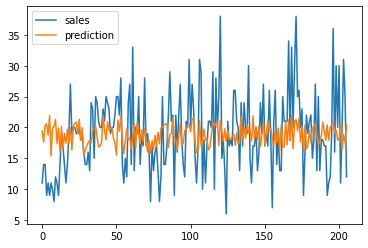

In [28]:
panda_df.plot()